<a href="https://colab.research.google.com/github/promckkon/MK-DCNN/blob/main/MK-DCNN%20with%2030dB%20NOISE%20in%20CWRU%20Dataset%20250617.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

Dataset Input

In [67]:
df=pd.DataFrame(columns=['DE_data','fault']) # upload the dataset on googledrive

for root, dirs, files in os.walk("/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_30", topdown=False):
    for file_name in files:
        path = os.path.join(root, file_name)
        print(path)

        mat = scipy.io.loadmat(path)

        key_name = list(mat.keys())[3]
        DE_data = mat.get(key_name)
        fault = np.full((len(DE_data), 1), file_name[:-4])

        df_temp = pd.DataFrame({'DE_data':np.ravel(DE_data) , 'fault':np.ravel(fault)})

        df = pd.concat([df,df_temp],axis=0)
        print(df['fault'].unique())

df.to_csv('/content/drive/MyDrive/MK-DCNN CWRU/NOISE_30_faults.csv',index=False)

/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_30/Noise_30_OR014_6_1_202.mat


<ipython-input-67-776554778>:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df_temp],axis=0)


['Noise_30_OR014_6_1_202']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_30/Noise_30_IR007_1_110.mat
['Noise_30_OR014_6_1_202' 'Noise_30_IR007_1_110']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_30/Noise_30_B007_1_123.mat
['Noise_30_OR014_6_1_202' 'Noise_30_IR007_1_110' 'Noise_30_B007_1_123']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_30/Noise_30_B021_1_227.mat
['Noise_30_OR014_6_1_202' 'Noise_30_IR007_1_110' 'Noise_30_B007_1_123'
 'Noise_30_B021_1_227']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_30/Noise_30_OR021_6_1_239.mat
['Noise_30_OR014_6_1_202' 'Noise_30_IR007_1_110' 'Noise_30_B007_1_123'
 'Noise_30_B021_1_227' 'Noise_30_OR021_6_1_239']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_30/Noise_30_OR007_6_1_136.mat
['Noise_30_OR014_6_1_202' 'Noise_30_IR007_1_110' 'Noise_30_B007_1_123'
 'Noise_30_B021_1_227' 'Noise_30_OR021_6_1_239' 'Noise_30_OR007_6_1_136']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_30/Noise_30__Time_Normal_1_098.mat
['

# Multi-Kernel Deep 1D-CNN

In [68]:
pip install -q tensorflow

In [69]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


# Total target rows
TARGET_ROWS = 1800

# Estimate the total number of samples across all fault types
total_samples = sum(len(df[df['fault'] == f]) for f in df['fault'].unique())

# Calculate suitable window size and stride
num_faults = 9
average_samples_per_fault = total_samples / num_faults
approx_windows_per_fault = TARGET_ROWS / num_faults
stride_ratio = 0.8  # Initial stride/window ratio

win_len = int(average_samples_per_fault / approx_windows_per_fault)
stride = int(win_len * stride_ratio)

X=[]
Y=[]


for k in df['fault'].unique():

    df_temp_2 = df[df['fault']==k]

    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])

X=np.array(X)
X=X.reshape((X.shape[0],-1,1))
#X = np.repeat(X, 3, axis=3) # To repeat into 3 chanel format


Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [70]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [71]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, concatenate
from tensorflow.keras import backend as K

# --- Custom Physics-Informed Loss Function ---
def custom_loss(y_true, y_pred):
    # Standard categorical crossentropy
    loss = K.categorical_crossentropy(y_true, y_pred)

    # Physics-Informed Term: penalize rapid class probability changes
    # Ensure y_pred is at least 2D for slicing
    if K.ndim(y_pred) < 2:
        y_pred = K.expand_dims(y_pred, axis=-1)

    # Ensure y_pred has more than one class dimension to compute diff
    if K.int_shape(y_pred)[-1] > 1:
        diff = y_pred[:, 1:] - y_pred[:, :-1]
        squared_diff = tf.square(diff)
        physics_term = tf.reduce_mean(squared_diff)
    else:
        physics_term = 0.0 # No physics term if only one class


    # Total loss = classification loss + regularization term
    total_loss = loss + 0.01 * physics_term  # 0.01 is tunable

    return total_loss

# --- Model Definition ---
# no_classes = len(df['fault'].unique()) # Original line that caused 10 classes
no_classes = len(encoder.classes_) # Use the encoder to get the correct number of classes
print(f"Number of output classes (no_classes): {no_classes}") # Add print statement to verify

input_shape = (X.shape[1], X.shape[2])  # Example: (784, 1)

# Head 1
inputs1 = Input(shape=input_shape)
conv1 = Conv1D(filters=64, kernel_size=200, activation='relu')(inputs1)
drop1 = Dropout(0.5)(conv1)
pool1 = MaxPooling1D(pool_size=20)(drop1)
flat1 = Flatten()(pool1)

# Head 2
inputs2 = Input(shape=input_shape)
conv2 = Conv1D(filters=64, kernel_size=100, activation='relu')(inputs2)
drop2 = Dropout(0.5)(conv2)
pool2 = MaxPooling1D(pool_size=10)(drop2)
flat2 = Flatten()(pool2)

# Head 3
inputs3 = Input(shape=input_shape)
conv3 = Conv1D(filters=64, kernel_size=50, activation='relu')(inputs3)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPooling1D(pool_size=5)(drop3)
flat3 = Flatten()(pool3)

# Merge all feature paths
merged = concatenate([flat1, flat2, flat3])

# Fully connected interpretation
dense1 = Dense(100, activation='relu')(merged)
outputs = Dense(no_classes, activation='softmax')(dense1)

# Build and compile model with custom loss
cnn_model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
cnn_model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

# Model summary
cnn_model.summary()

Number of output classes (no_classes): 9


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 2431, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 2431, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 2431, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 2232, 64)  │     12,864 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 2332, 64)  │      6,464 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 2382, 64)  │      3,264 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 2232, 64)  │          0 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 2332, 64)  │          0 │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 2382, 64)  │          0 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 111, 64)   │          0 │ dropout_6[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 233, 64)   │          0 │ dropout_7[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 476, 64)   │          0 │ dropout_8[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 7104)      │          0 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 14912)     │          0 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 30464)     │          0 │ max_pooling1d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 52480)     │          0 │ flatten_6[0][0],  │
│ (Concatenate)       │                   │            │ flatten_7[0][0],  │
│                     │                   │            │ flatten_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 100)       │  5,248,100 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 9)         │        909 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,271,601 (20.11 MB)

 Trainable params: 5,271,601 (20.11 MB)

 Non-trainable params: 0 (0.00 B)

In [72]:
batch_size =100
epochs = 20
history = cnn_model.fit([X_train,X_train,X_train], y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=([X_test,X_test,X_test],y_test),shuffle=True)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 918ms/step - accuracy: 0.1500 - loss: 4.1933 - val_accuracy: 0.2953 - val_loss: 1.7514
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.3502 - loss: 1.5243 - val_accuracy: 0.5223 - val_loss: 1.4041
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6298 - loss: 1.0581 - val_accuracy: 0.7285 - val_loss: 1.0232
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8177 - loss: 0.6882 - val_accuracy: 0.8858 - val_loss: 0.6845
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9599 - loss: 0.3259 - val_accuracy: 0.9585 - val_loss: 0.4257
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9802 - loss: 0.1589 - val_accuracy: 0.9614 - val_loss: 0.3087
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9909 - loss: 0.0912 - val_accuracy: 0.9614 - val_loss: 0.2613
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9833 - loss: 0.0719 - val_accuracy: 0.9733 

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


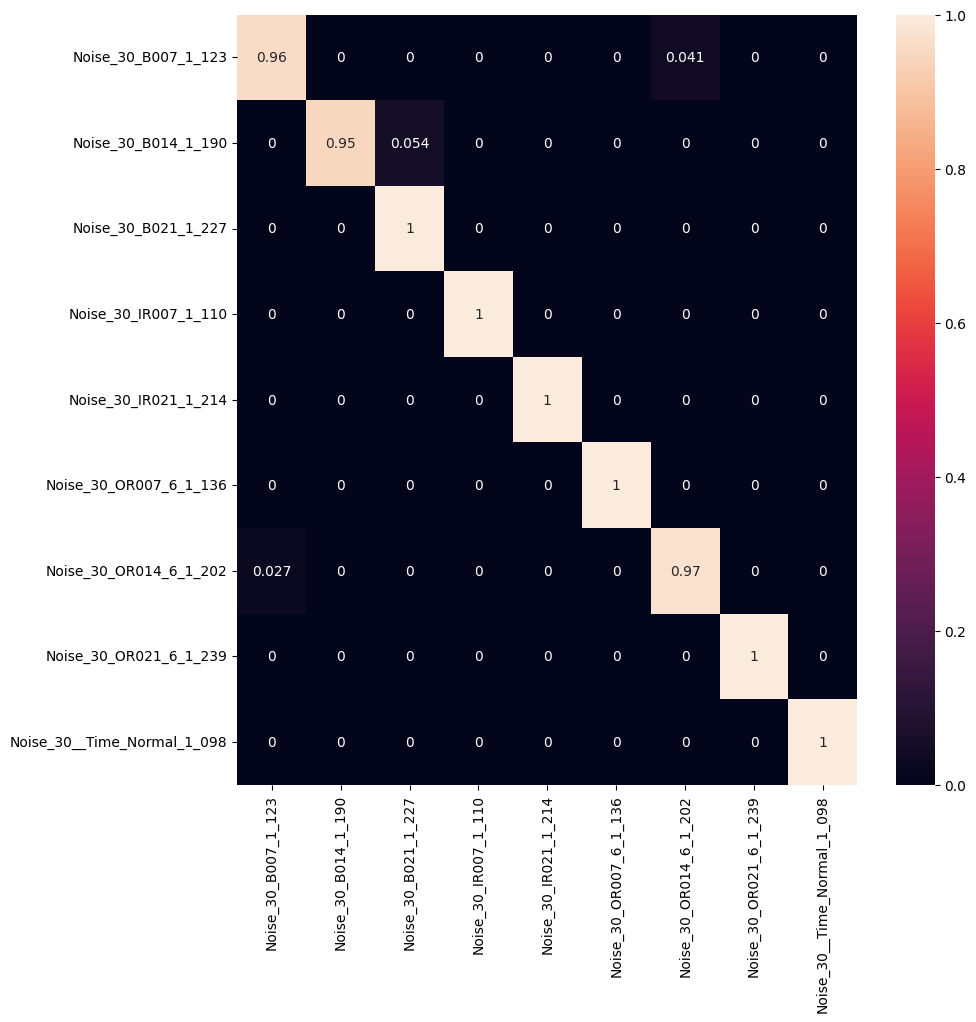

In [73]:
def inv_Transform_result(y_pred):
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict([X_test,X_test,X_test])


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_)

In [74]:
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[16].output)
y_viz = dummy_cnn.predict([X_train,X_train,X_train])

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1570 samples in 0.001s...
[t-SNE] Computed neighbors for 1570 samples in 0.167s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1570
[t-SNE] Computed conditional probabilities for sample 1570 / 1570
[t-SNE] Mean sigma: 1.543808
[t-SNE] Computed conditional probabilities in 0.059s
[t-SNE] Iteration 50: error = 56.9464645, gradient norm = 0.0426516 (50 iterations in 0.650s)
[t-SNE] Iteration 100: error = 51.9206085, gradient norm = 0.0164214 (50 iterations in 0.448s)
[t-SNE] Iteration 150: error = 50.6736450, gradient norm = 0.0105314 (50 iterations in 0.462s)
[t-SNE] Iteration 200: error = 50.0704002, gradient norm = 0.0094486 (50 iterations in 0.445s)
[t-SNE] Iteration 250: error = 49.6964722, gradient norm = 0.0068450 (50 iterations in 0.466s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.696472
[t-SNE] Iteration 300: error = 0.8793728, gradient norm = 0.0170000 (50 iterations in 0.608s

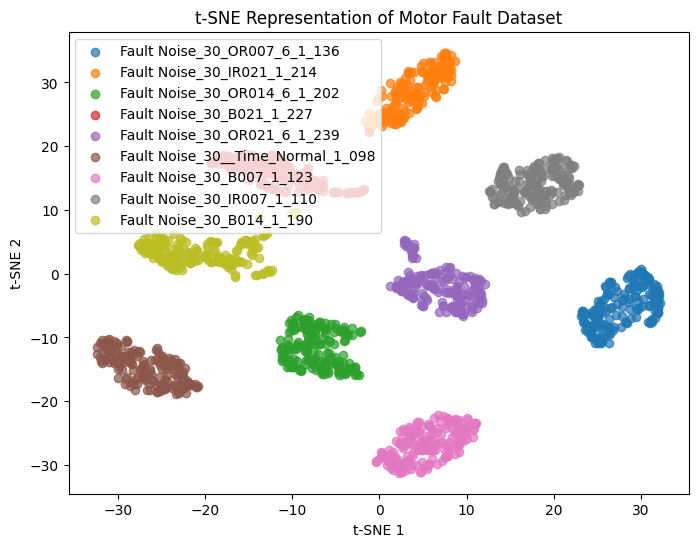

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Apply t-SNE transformation
X_t_sne = TSNE(
    n_components=2,
    learning_rate='auto',
    verbose=2,  # Increase verbosity for more detailed feedback
    perplexity=40,
    n_iter=500  # Slightly increased number of iterations for convergence
).fit_transform(y_viz)

# Create DataFrame for t-SNE components
tSNEdf = pd.DataFrame(data=X_t_sne, columns=['T-SNE component 1', 'T-SNE component 2'])

# Assuming `inv_Transform_result` transforms `y_train` to get the Fault labels
tSNEdf['Fault'] = inv_Transform_result(y_train)

# Save the t-SNE DataFrame as a CSV file
tSNEdf.to_csv('/content/drive/MyDrive/MK-DCNN CWRU/NOISE_30_tSNE_results.csv', index=True)
print("t-SNE results saved as '/content/drive/MyDrive/MK-DCNN CWRU/NOISE_30_tSNE_results.csv'.")

# # Plot the t-SNE results with Fault as hue
# plt.figure(figsize=(12, 12))  # Larger figure for clarity
# sns.scatterplot(
#     x='T-SNE component 1',
#     y='T-SNE component 2',
#     hue='Fault',
#     palette=sns.color_palette("husl", as_cmap=False),  # Vivid color palette
#     data=tSNEdf,
#     legend="full",
#     alpha=0.7,  # Increased transparency for better overlap clarity
#     s=100  # Larger marker size
# )

# # Add gridlines for better visualization
# plt.grid


# Optional: Visualization of t-SNE representation
plt.figure(figsize=(8, 6))
for label in tSNEdf['Fault'].unique():
    subset = tSNEdf[tSNEdf['Fault'] == label]
    plt.scatter(subset['T-SNE component 1'], subset['T-SNE component 2'], label=f'Fault {label}', alpha=0.7)

plt.title('t-SNE Representation of Motor Fault Dataset')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()

Statistical Features

In [76]:
import numpy as np
from scipy.stats import skew, kurtosis
import pandas as pd
import matplotlib.pyplot as plt

# Total target rows
TARGET_ROWS = 1800

# Estimate the total number of samples across all fault types
total_samples = sum(len(df[df['fault'] == f]) for f in df['fault'].unique())

# Calculate suitable window size and stride
num_faults = 9
average_samples_per_fault = total_samples / num_faults
approx_windows_per_fault = TARGET_ROWS / num_faults
stride_ratio = 0.8  # Initial stride/window ratio

WINDOW_SIZE = int(average_samples_per_fault / approx_windows_per_fault)
STRIDE = int(WINDOW_SIZE * stride_ratio)

print(f"Calculated WINDOW_SIZE: {WINDOW_SIZE}, STRIDE: {STRIDE}")

# Initialize a list to store statistical features
statistical_features = []

# Loop through each fault type
for f in df['fault'].unique():
    # Extract data for the current fault type
    fault_data = df[df['fault'] == f].iloc[:, 0].values  # Convert to NumPy array for efficiency

    # Compute windows using sliding window approach
    num_windows = (len(fault_data) - WINDOW_SIZE) // STRIDE + 1
    for i in range(num_windows):
        start = i * STRIDE
        end = start + WINDOW_SIZE
        window = fault_data[start:end]

        # Compute statistical features for the current window
        mean_val = np.mean(window)
        std_val = np.std(window)
        rms_val = np.sqrt(np.mean(np.square(window)))
        max_val = np.max(window)
        min_val = np.min(window)
        skewness_val = skew(window)
        kurtosis_val = kurtosis(window)

        # Additional statistical features
        mean_abs_val = np.mean(np.abs(window))
        form_factor = rms_val / mean_abs_val if mean_abs_val != 0 else 0
        crest_factor = max_val / rms_val if rms_val != 0 else 0

        # Store the features in a dictionary
        statistical_features.append({
            'fault': f,
            'window': i + 1,
            'mean': mean_val,
            'std': std_val,
            'rms': rms_val,
            'max': max_val,
            'min': min_val,
            'skewness': skewness_val,
            'kurtosis': kurtosis_val,
            'form_factor': form_factor,
            'crest_factor': crest_factor
        })

# Convert statistical features into a DataFrame
stat_features_df = pd.DataFrame(statistical_features)

# Display the extracted features and count of rows
print(f"Extracted {len(stat_features_df)} rows (target: {TARGET_ROWS})")
print(stat_features_df)

# Save the extracted features to a CSV file
output_file = "/content/drive/MyDrive/MK-DCNN CWRU/NOISE_30_statistical_features_with_form_and_crest_factors.csv"
stat_features_df.to_csv(output_file, index=False)
print(f"Statistical features saved to '{output_file}'.")


Calculated WINDOW_SIZE: 2431, STRIDE: 1944
Extracted 2244 rows (target: 1800)
                       fault  window      mean       std       rms       max  \
0     Noise_30_OR014_6_1_202       1  0.014744  0.139971  0.140746  0.544207   
1     Noise_30_OR014_6_1_202       2  0.013560  0.140150  0.140804  0.544207   
2     Noise_30_OR014_6_1_202       3  0.012855  0.143838  0.144411  0.444594   
3     Noise_30_OR014_6_1_202       4  0.012589  0.146474  0.147014  0.572674   
4     Noise_30_OR014_6_1_202       5  0.010980  0.133674  0.134124  0.527233   
...                      ...     ...       ...       ...       ...       ...   
2239     Noise_30_B014_1_190     245  0.010171  0.220593  0.220827  0.977381   
2240     Noise_30_B014_1_190     246  0.009995  0.241861  0.242067  1.808761   
2241     Noise_30_B014_1_190     247  0.008777  0.312457  0.312580  1.808761   
2242     Noise_30_B014_1_190     248  0.009700  0.127419  0.127787  0.502797   
2243     Noise_30_B014_1_190     249  0.00

In [77]:
import pandas as pd
from sklearn.utils import resample

# Load your dataset (replace 'your_dataset.csv' with your actual file)
df = pd.read_csv('/content/drive/MyDrive/MK-DCNN CWRU/NOISE_30_statistical_features_with_form_and_crest_factors.csv')

# Display initial class distribution
print("Initial class distribution:")
print(df['fault'].value_counts())

# Target size for undersampling/resampling
TARGET_ROWS = 1570

# Separate all fault types
fault_classes = df['fault'].value_counts()

# Determine the number of classes
num_classes = len(fault_classes)

# Calculate how many samples to take from each class
samples_per_class = TARGET_ROWS // num_classes

# Initialize a list to store resampled data
resampled_data = []

# Loop over each class to resample them
for fault_class in fault_classes.index:
    class_data = df[df['fault'] == fault_class]
    if len(class_data) > samples_per_class:
        # Undersample
        class_data_resampled = resample(class_data, replace=False, n_samples=samples_per_class, random_state=42)
    else:
        # Upsample
        class_data_resampled = resample(class_data, replace=True, n_samples=samples_per_class, random_state=42)

    resampled_data.append(class_data_resampled)

# Concatenate the resampled data into a single DataFrame
balanced_df = pd.concat(resampled_data)

# Check if we have the exact number of rows
current_rows = len(balanced_df)
print(f"Current rows after equal resampling: {current_rows}")

# If the current rows don't match the target rows, adjust by trimming or adding rows
if current_rows > TARGET_ROWS:
    # Trim extra rows (if more than target)
    balanced_df = balanced_df.head(TARGET_ROWS)
elif current_rows < TARGET_ROWS:
    # Add rows if fewer than target, by sampling from existing data
    remaining_rows = TARGET_ROWS - current_rows
    additional_data = balanced_df.sample(n=remaining_rows, replace=True, random_state=42)
    balanced_df = pd.concat([balanced_df, additional_data])

# Shuffle the final dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display new class distribution
print("New class distribution:")
print(balanced_df['fault'].value_counts())

# Display final row count
print(f"Final row count: {len(balanced_df)}")

# Save the balanced dataset to a CSV file
balanced_df.to_csv("/content/drive/MyDrive/MK-DCNN CWRU/NOISE_30_balanced_dataset_equal_resampling_exact_1570.csv", index=False)
print("Balanced dataset saved as '/content/drive/MyDrive/MK-DCNN CWRU/NOISE_30_balanced_dataset_equal_resampling_exact_1570.csv'")


Initial class distribution:
fault
Noise_30_OR021_6_1_239         251
Noise_30_B021_1_227            250
Noise_30_B007_1_123            250
Noise_30_OR007_6_1_136         250
Noise_30_IR007_1_110           249
Noise_30_B014_1_190            249
Noise_30_IR021_1_214           249
Noise_30_OR014_6_1_202         248
Noise_30__Time_Normal_1_098    248
Name: count, dtype: int64
Current rows after equal resampling: 1566
New class distribution:
fault
Noise_30__Time_Normal_1_098    175
Noise_30_IR021_1_214           175
Noise_30_OR014_6_1_202         175
Noise_30_IR007_1_110           175
Noise_30_B014_1_190            174
Noise_30_OR007_6_1_136         174
Noise_30_B007_1_123            174
Noise_30_B021_1_227            174
Noise_30_OR021_6_1_239         174
Name: count, dtype: int64
Final row count: 1570
Balanced dataset saved as '/content/drive/MyDrive/MK-DCNN CWRU/NOISE_30_balanced_dataset_equal_resampling_exact_1570.csv'


In [78]:
balanced_df.shape

(1570, 11)

In [79]:
balanced_df=balanced_df.sort_values(by='fault')

In [80]:
balanced_df

,fault,window,mean,std,rms,max,min,skewness,kurtosis,form_factor,crest_factor
142,Noise_30_B007_1_123,6,0.021241,0.139363,0.140973,0.448443,-0.579687,-0.191660,0.265808,1.259957,3.181064
162,Noise_30_B007_1_123,69,0.019098,0.142004,0.143283,0.466184,-0.394619,-0.041804,-0.184901,1.237422,3.253598
478,Noise_30_B007_1_123,115,0.017360,0.142127,0.143183,0.428490,-0.433003,-0.094253,-0.209339,1.244253,2.992602
477,Noise_30_B007_1_123,83,0.018550,0.131633,0.132933,0.416486,-0.355287,0.085955,-0.216941,1.248125,3.133040
476,Noise_30_B007_1_123,133,0.018960,0.147302,0.148518,0.581433,-0.437825,0.096610,0.075030,1.261044,3.914904
...,...,...,...,...,...,...,...,...,...,...,...
340,Noise_30__Time_Normal_1_098,85,0.013062,0.068586,0.069819,0.258904,-0.230803,-0.104112,0.043592,1.240648,3.708231
344,Noise_30__Time_Normal_1_098,65,0.011231,0.068548,0.069462,0.191294,-0.235260,-0.240814,0.004887,1.256640,2.753944
1213,Noise_30__Time_Normal_1_098,16,0.009955,0.064913,0.065671,0.191726,-0.189783,-0.157600,-0.306704,1.225726,2.919466
330,Noise_30__Time_Normal_1_098,17,0.010163,0.063177,0.063989,0.205183,-0.251512,-0.217917,-0.101233,1.229509,3.206535


     t-SNE 1    t-SNE 2                fault
0  22.014355  24.259617  Noise_30_B007_1_123
1  40.794998   1.735937  Noise_30_B007_1_123
2  30.981190   3.330296  Noise_30_B007_1_123
3  40.821762   2.640985  Noise_30_B007_1_123
4  14.792961  14.689573  Noise_30_B007_1_123


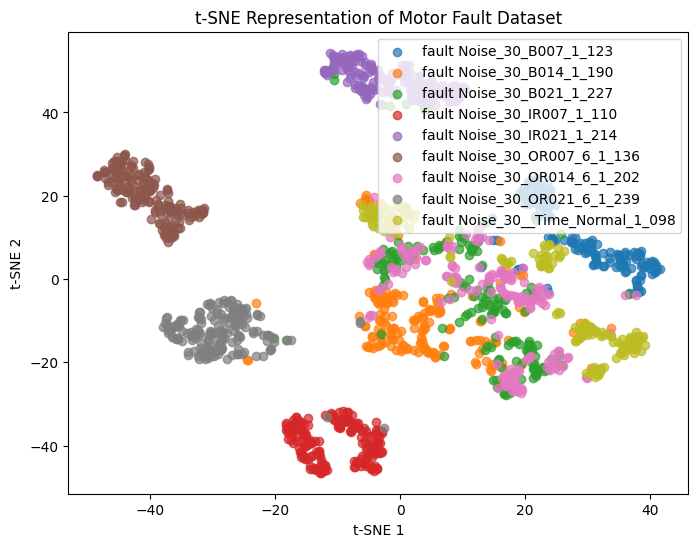

In [81]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Sort the dataset by the 'Fault' column
balanced_df = balanced_df.sort_values(by='fault')

# Separate features and target variable
X = balanced_df.drop(columns=['fault'])  # Replace 'Fault' with actual target column name
y = balanced_df['fault']

# Normalize the feature columns using StandardScaler
scaler = StandardScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Concatenate the normalized features with the target variable
STAT_Motor_Fault_dataset_normalized = pd.concat([X_normalized, y.reset_index(drop=True)], axis=1)

# Sort the normalized dataset by 'Fault' column
STAT_Motor_Fault_dataset_normalized = STAT_Motor_Fault_dataset_normalized.sort_values(by='fault')

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)  # 2D t-SNE
X_tsne = tsne.fit_transform(X_normalized)

# Create a DataFrame for t-SNE results
tSNE_representation = pd.DataFrame(X_tsne, columns=['t-SNE 1', 't-SNE 2'])
tSNE_representation['fault'] = y.reset_index(drop=True)

# Display the t-SNE representation
print(tSNE_representation.head())

# Optional: Visualization of t-SNE representation
plt.figure(figsize=(8, 6))
for label in tSNE_representation['fault'].unique():
    subset = tSNE_representation[tSNE_representation['fault'] == label]
    plt.scatter(subset['t-SNE 1'], subset['t-SNE 2'], label=f'fault {label}', alpha=0.7)

plt.title('t-SNE Representation of Motor Fault Dataset')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()


In [82]:
tSNE_representation

,t-SNE 1,t-SNE 2,fault
0,22.014355,24.259617,Noise_30_B007_1_123
1,40.794998,1.735937,Noise_30_B007_1_123
2,30.981190,3.330296,Noise_30_B007_1_123
3,40.821762,2.640985,Noise_30_B007_1_123
4,14.792961,14.689573,Noise_30_B007_1_123
...,...,...,...
1565,35.775745,-17.510893,Noise_30__Time_Normal_1_098
1566,-4.234982,15.693857,Noise_30__Time_Normal_1_098
1567,35.221943,-17.873384,Noise_30__Time_Normal_1_098
1568,21.248219,6.348327,Noise_30__Time_Normal_1_098


In [83]:
tSNE_representation=tSNE_representation.drop(columns=['fault'])
tSNE_representation

,t-SNE 1,t-SNE 2
0,22.014355,24.259617
1,40.794998,1.735937
2,30.981190,3.330296
3,40.821762,2.640985
4,14.792961,14.689573
...,...,...
1565,35.775745,-17.510893
1566,-4.234982,15.693857
1567,35.221943,-17.873384
1568,21.248219,6.348327


In [84]:
tSNEdf = tSNEdf.sort_values(by='Fault')

In [85]:
tSNEdf

,T-SNE component 1,T-SNE component 2,Fault
468,2.456237,-31.080555,Noise_30_B007_1_123
1072,8.985518,-26.565369,Noise_30_B007_1_123
754,7.318918,-22.387716,Noise_30_B007_1_123
1074,3.105047,-29.367151,Noise_30_B007_1_123
1075,3.532399,-25.766329,Noise_30_B007_1_123
...,...,...,...
160,-30.139868,-12.252323,Noise_30__Time_Normal_1_098
1094,-29.739746,-14.034339,Noise_30__Time_Normal_1_098
1093,-27.446779,-15.003716,Noise_30__Time_Normal_1_098
1109,-29.475639,-13.538272,Noise_30__Time_Normal_1_098


Combined Features

In [86]:
# import pandas as pd

# Assuming df1 and df2 are your two dataframes
# Concatenate the dataframes vertically
Motor_Fault_dataset = pd.concat([tSNE_representation, tSNEdf], axis=1)
Motor_Fault_dataset=Motor_Fault_dataset.sort_values(by='Fault')
Motor_Fault_dataset

import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming df1 and df2 are your two dataframes
# Concatenate the dataframes vertically
Motor_Fault_dataset = pd.concat([tSNE_representation, tSNEdf], axis=1)

# Sort the dataset by 'Fault' column
Motor_Fault_dataset = Motor_Fault_dataset.sort_values(by='Fault')
Motor_Fault_dataset


,t-SNE 1,t-SNE 2,T-SNE component 1,T-SNE component 2,Fault
468,10.611337,-1.893354,2.456237,-31.080555,Noise_30_B007_1_123
1072,15.737379,-13.357326,8.985518,-26.565369,Noise_30_B007_1_123
754,-4.519254,50.094833,7.318918,-22.387716,Noise_30_B007_1_123
1074,17.913212,-26.784925,3.105047,-29.367151,Noise_30_B007_1_123
1075,16.362328,-23.862997,3.532399,-25.766329,Noise_30_B007_1_123
...,...,...,...,...,...
160,39.623669,4.173255,-30.139868,-12.252323,Noise_30__Time_Normal_1_098
1094,8.296582,3.460801,-29.739746,-14.034339,Noise_30__Time_Normal_1_098
1093,23.273930,-6.226921,-27.446779,-15.003716,Noise_30__Time_Normal_1_098
1109,8.923097,0.470542,-29.475639,-13.538272,Noise_30__Time_Normal_1_098


In [87]:
#Classification Report for MKDCNN

HSPSO-CatBoost


In [88]:
X = Motor_Fault_dataset.iloc[:, 0:4].values
y = Motor_Fault_dataset.iloc[:, 4].values

In [89]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [90]:
pip install -q hyperactive

In [91]:
pip install -q catboost

Deployment:

In [92]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier, Pool
from hyperactive import Hyperactive
from hyperactive.optimizers import ParticleSwarmOptimizer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === DATA: Replace X_train, X_test, y_train, y_test with your actual data ===
# Example:
# X_train, X_test, y_train, y_test = train_test_split(...)

X, y = X_train, y_train

# === Objective Function ===
def model(opt):
    CatBoost = CatBoostClassifier(
        iterations=opt["iterations"],
        depth=opt["depth"],
        learning_rate=opt["learning_rate"],
        l2_leaf_reg=opt["l2_leaf_reg"],
        bagging_temperature=opt["bagging_temperature"],
        random_strength=opt["random_strength"],
        verbose=False
    )
    scores = cross_val_score(CatBoost, X, y, cv=4)
    return scores.mean()

# === Search Space ===
search_space = {
    "iterations": list(range(50, 501, 50)),
    "depth": list(range(1, 11)),
    "learning_rate": [0.01, 0.05, 0.1],
    "l2_leaf_reg": [1, 3, 5],
    "bagging_temperature": [0.5, 1, 1.5],
    "random_strength": [0.5, 1, 1.5],
}

# === Cauchy Mutation ===
def cauchy_mutation(particle, gamma=0.3):
    for key in particle:
        if isinstance(particle[key], (int, float)):
            particle[key] = particle[key] * (1 + gamma * np.tan(np.pi * (np.random.rand() - 0.5)))
            particle[key] = np.clip(particle[key], min(search_space[key]), max(search_space[key]))
            if isinstance(search_space[key][0], int):
                particle[key] = int(round(particle[key]))
    return particle

# === HSPSO Optimizer Class ===
class HybridStrategyPSO(ParticleSwarmOptimizer):
    def __init__(self, n_part=20, max_iter=40, **kwargs):
        super().__init__(**kwargs)
        self.switch_threshold = 10
        self.iteration = 0
        self.topology = "gbest"
        self.n_part = n_part
        self.max_iter = max_iter

        # Adaptive Inertia Parameters
        self.H = 1
        self.w_min = 0.4
        self.w_max = 0.9
        self.b = 0.9
        self.scaling_factor = 0.5

    def on_iteration(self, swarm, scores):
        self.iteration += 1

        # === Topology Switching ===
        if self.iteration % self.switch_threshold == 0:
            self.topology = "lbest" if self.topology == "gbest" else "gbest"
            self.set_topology(self.topology)

        # === Clone Best Particles ===
        best_indices = np.argsort(scores)[:max(1, len(swarm) // 5)]
        for idx in best_indices:
            particle = swarm[idx].copy()
            swarm.append(particle)
            scores.append(scores[idx])

        # === Prune Worst Particles ===
        if len(swarm) > 2 * self.n_part:
            worst_indices = np.argsort(scores)[-len(swarm)//4:]
            for i in reversed(worst_indices):
                del swarm[i]
                del scores[i]

        # === Nonlinear Adaptive Inertia ===
        numerator = (self.w_max - self.w_min) * self.iteration
        denominator = 1 + np.exp(-10 * self.b * ((2 * self.iteration) / (self.H * self.max_iter) - 1))
        self.inertia = self.w_max - numerator / denominator

        # === Cauchy Mutation ===
        for i in range(len(swarm)):
            if np.random.rand() < 0.2:
                swarm[i] = cauchy_mutation(swarm[i])

        # === Hook-Jeeves Local Search (simplified) ===
        top_ids = np.argsort(scores)[:2]
        for i in top_ids:
            particle = swarm[i]
            for key in particle:
                if isinstance(particle[key], (int, float)):
                    for delta in [-0.01, 0.01] if isinstance(particle[key], float) else [-1, 1]:
                        trial = particle.copy()
                        trial[key] = trial[key] + delta
                        trial[key] = np.clip(trial[key], min(search_space[key]), max(search_space[key]))
                        if isinstance(search_space[key][0], int):
                            trial[key] = int(round(trial[key]))
                        trial_score = model(trial)
                        if trial_score > scores[i]:
                            swarm[i] = trial
                            scores[i] = trial_score

        # === Random Restart ===
        if np.random.rand() < 0.1:
            random_idx = np.random.choice(len(swarm))
            for key in swarm[random_idx]:
                if isinstance(swarm[random_idx][key], (int, float)):
                    swarm[random_idx][key] = np.random.choice(search_space[key])

# === Run HSPSO Hyperparameter Tuning ===
start_time = datetime.now()

hyper = Hyperactive()

optimizer = HybridStrategyPSO(
    n_part=20,
    max_iter=40,
    inertia=0.5,
    cognitive_weight=0.9,
    social_weight=0.5,
    temp_weight=0.4,
    rand_rest_p=0.05,
)

hyper.add_search(model, search_space, optimizer=optimizer, n_iter=40)
hyper.run()

end_time = datetime.now()
print('Tuning Duration:', end_time - start_time)

# === Best Parameters ===
best_params = hyper.best_para(model)
print("Best Parameters:", best_params)

# === Train Final Model with Best Parameters ===
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)

final_model = CatBoostClassifier(
    depth=best_params["depth"],
    iterations=best_params["iterations"],
    learning_rate=best_params["learning_rate"],
    l2_leaf_reg=best_params["l2_leaf_reg"],
    bagging_temperature=best_params["bagging_temperature"],
    random_strength=best_params["random_strength"],
    verbose=10
)

final_model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=best_params["iterations"] // 10,
    plot=True
)


[0] model (Particle Swarm Optimization): 100%|──────────| 40/40 [05:59<00:00,  9.00s/it, best_iter=0, best_pos=None, best_score=-inf]



Results: 'model'  
   Best score: 1.0  
   Best parameter set:
      'iterations'          : 50.0  
      'depth'               : 9.0  
      'learning_rate'       : 0.1  
      'l2_leaf_reg'         : 1.0  
      'bagging_temperature' : 1.5  
      'random_strength'     : 0.5  
   Best iteration: 0  
 
   Random seed: 2087814699  
 
   Evaluation time   : 359.7525956630707 sec    [100.0 %]
   Optimization time : 0.009143829345703125 sec    [0.0 %]
   Iteration time    : 359.7617394924164 sec    [8.99 sec/iter]
 
Tuning Duration: 0:06:00.097742
Best Parameters: {'iterations': 50, 'depth': 9, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'bagging_temperature': 1.5, 'random_strength': 0.5}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.5401724	test: 1.5402200	best: 1.5402200 (0)	total: 53.6ms	remaining: 2.63s
5:	learn: 0.6676989	test: 0.6804350	best: 0.6804350 (5)	total: 288ms	remaining: 2.11s
10:	learn: 0.3730438	test: 0.3877516	best: 0.3877516 (10)	total: 532ms	remaining: 1.89s
15:	learn: 0.2243863	test: 0.2387110	best: 0.2387110 (15)	total: 750ms	remaining: 1.59s
20:	learn: 0.1404228	test: 0.1533337	best: 0.1533337 (20)	total: 932ms	remaining: 1.29s
25:	learn: 0.0915100	test: 0.1034716	best: 0.1034716 (25)	total: 1.16s	remaining: 1.07s
30:	learn: 0.0628513	test: 0.0756393	best: 0.0756393 (30)	total: 1.38s	remaining: 844ms
35:	learn: 0.0439898	test: 0.0567580	best: 0.0567580 (35)	total: 1.61s	remaining: 628ms
40:	learn: 0.0312805	test: 0.0439998	best: 0.0439998 (40)	total: 1.83s	remaining: 403ms
45:	learn: 0.0225434	test: 0.0354674	best: 0.0354674 (45)	total: 2.06s	remaining: 179ms
49:	learn: 0.0184151	test: 0.0317217	best: 0.0317217 (49)	total: 2.23s	remaining: 0us

bestTest = 0.03172166234
bestIterati

In [93]:
hyper.add_search(model, search_space, optimizer=optimizer, n_iter=40, initialize={"random": 20})


In [94]:
learning_curve = final_model.get_evals_result()
print(learning_curve)

{'learn': {'MultiClass': [1.5401724038700966, 1.231456627886622, 1.031399125845233, 0.8777411157059032, 0.7582840455805, 0.6676989345276837, 0.587423762938884, 0.5214851711700379, 0.4626337409057202, 0.41359318754197116, 0.3730438150193917, 0.3364955940388225, 0.3032260617721548, 0.2730922376983345, 0.24767287882825428, 0.22438627283592052, 0.2021911971122478, 0.1840182584014078, 0.16822262169604998, 0.1534322371529931, 0.14042275119614028, 0.12882586929055567, 0.1192983112281791, 0.10958010824980362, 0.10018630845995577, 0.09150998610335806, 0.08385148595164285, 0.07727307680132077, 0.07268943973098677, 0.06812990639038338, 0.06285132125989559, 0.05848909633815902, 0.05441211922730641, 0.050626350363676076, 0.04717749152730434, 0.043989770184818394, 0.04076109122491979, 0.03810219464875326, 0.03582764712651986, 0.03369278170762099, 0.03128045061363879, 0.029268283356329285, 0.0273005314992835, 0.025587713397771245, 0.024040844272051755, 0.022543444646334156, 0.02149631215866822, 0.020

In [95]:
# Retrieve evaluation results
learning_curve = final_model.get_evals_result()

# Extract the metric values
# Assuming 'learn' corresponds to the training dataset
train_metric_values = learning_curve.get('learn', {}).get('MultiClass', [])

# Check the extracted values
if train_metric_values:
    print("Training metric values:", train_metric_values)
else:
    print("Metric 'MultiClass' not found in evaluation results.")


Training metric values: [1.5401724038700966, 1.231456627886622, 1.031399125845233, 0.8777411157059032, 0.7582840455805, 0.6676989345276837, 0.587423762938884, 0.5214851711700379, 0.4626337409057202, 0.41359318754197116, 0.3730438150193917, 0.3364955940388225, 0.3032260617721548, 0.2730922376983345, 0.24767287882825428, 0.22438627283592052, 0.2021911971122478, 0.1840182584014078, 0.16822262169604998, 0.1534322371529931, 0.14042275119614028, 0.12882586929055567, 0.1192983112281791, 0.10958010824980362, 0.10018630845995577, 0.09150998610335806, 0.08385148595164285, 0.07727307680132077, 0.07268943973098677, 0.06812990639038338, 0.06285132125989559, 0.05848909633815902, 0.05441211922730641, 0.050626350363676076, 0.04717749152730434, 0.043989770184818394, 0.04076109122491979, 0.03810219464875326, 0.03582764712651986, 0.03369278170762099, 0.03128045061363879, 0.029268283356329285, 0.0273005314992835, 0.025587713397771245, 0.024040844272051755, 0.022543444646334156, 0.02149631215866822, 0.0202

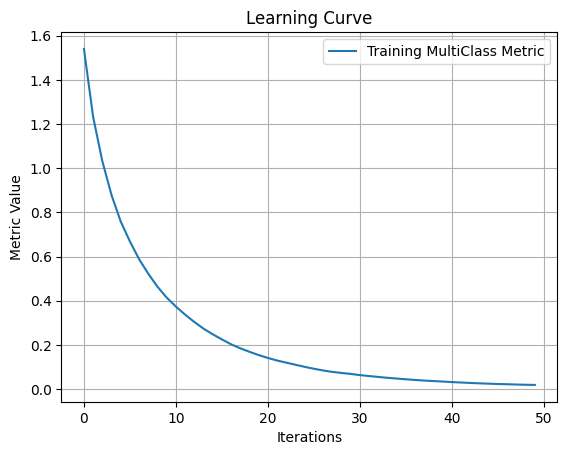

In [96]:
import matplotlib.pyplot as plt

# Plotting the learning curve
plt.plot(train_metric_values, label='Training MultiClass Metric')
plt.xlabel('Iterations')
plt.ylabel('Metric Value')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()


Classification Report - Training Set:
                             precision    recall  f1-score   support

        Noise_30_B007_1_123       1.00      1.00      1.00       147
        Noise_30_B014_1_190       1.00      1.00      1.00       132
        Noise_30_B021_1_227       1.00      1.00      1.00       140
       Noise_30_IR007_1_110       1.00      1.00      1.00       140
       Noise_30_IR021_1_214       1.00      1.00      1.00       138
     Noise_30_OR007_6_1_136       1.00      1.00      1.00       146
     Noise_30_OR014_6_1_202       1.00      1.00      1.00       130
     Noise_30_OR021_6_1_239       1.00      1.00      1.00       141
Noise_30__Time_Normal_1_098       1.00      1.00      1.00       142

                   accuracy                           1.00      1256
                  macro avg       1.00      1.00      1.00      1256
               weighted avg       1.00      1.00      1.00      1256

Classification Report - Test Set:
                            

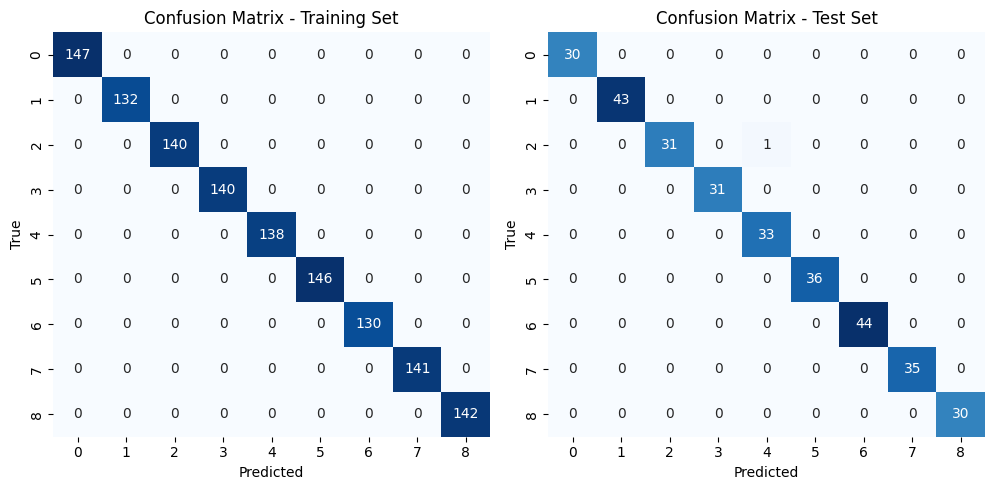

Deployment Duration: 0:06:03.935777


In [97]:
# Predictions
y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

print("Classification Report - Training Set:")
print(classification_report(y_train, y_pred_train))

print("Classification Report - Test Set:")
print(classification_report(y_test, y_pred_test))

conf_matrix_train = confusion_matrix(y_train, y_pred_train)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Training Set")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.subplot(1, 3, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.tight_layout()
plt.savefig('C-Matrix.svg', format='svg')
plt.show()

end_time = datetime.now()
print('Deployment Duration: {}'.format(end_time - start_time))

In [98]:
final_model.fit(X_train, y_train, eval_set=(X_test, y_test))

# Evaluate train accuracy
result_train = final_model.score(X_train, y_train)
print("Train Accuracy : {}".format(result_train))

# Evaluate test accuracy
result_test = final_model.score(X_test, y_test)
print("Test Accuracy : {}".format(result_test))

# Predictions
y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

# Classification report
print("Classification Report - Training Set:")
print(classification_report(y_train, y_pred_train))

print("Classification Report - Test Set:")
print(classification_report(y_test, y_pred_test))

0:	learn: 1.5401724	test: 1.5402200	best: 1.5402200 (0)	total: 94.5ms	remaining: 4.63s
10:	learn: 0.3730438	test: 0.3877516	best: 0.3877516 (10)	total: 909ms	remaining: 3.22s
20:	learn: 0.1404228	test: 0.1533337	best: 0.1533337 (20)	total: 1.92s	remaining: 2.66s
30:	learn: 0.0628513	test: 0.0756393	best: 0.0756393 (30)	total: 3.36s	remaining: 2.06s
40:	learn: 0.0312805	test: 0.0439998	best: 0.0439998 (40)	total: 4.81s	remaining: 1.06s
49:	learn: 0.0184151	test: 0.0317217	best: 0.0317217 (49)	total: 5.92s	remaining: 0us

bestTest = 0.03172166234
bestIteration = 49

Train Accuracy : 1.0
Test Accuracy : 0.9968152866242038
Classification Report - Training Set:
                             precision    recall  f1-score   support

        Noise_30_B007_1_123       1.00      1.00      1.00       147
        Noise_30_B014_1_190       1.00      1.00      1.00       132
        Noise_30_B021_1_227       1.00      1.00      1.00       140
       Noise_30_IR007_1_110       1.00      1.00      1.00